#### Reconstrucción 3D usando PyCOLMAP

In [1]:
import shutil
from pathlib import Path

import enlighten

import pycolmap
from pycolmap import logging

import open3d as o3d

In [2]:
def incremental_mapping_with_pbar(database_path, image_path, sfm_path):
    num_images = pycolmap.Database(database_path).num_images
    with enlighten.Manager() as manager:
        with manager.counter(
            total=num_images, desc="Images registered:"
        ) as pbar:
            pbar.update(0, force=True)
            reconstructions = pycolmap.incremental_mapping(
                database_path,
                image_path,
                sfm_path,
                initial_image_pair_callback=lambda: pbar.update(2),
                next_image_callback=lambda: pbar.update(1),
            )
    return reconstructions

Este código realiza una reconstrucción incremental con COLMAP, mostrando el progreso con enlighten, actualizando la barra conforme se registran imágenes y devolviendo los modelos reconstruidos.

In [3]:
output_path = Path("C:/Users/Usuario/Escritorio/SantiagoCruz_JuanPacheco")
image_path = output_path / "imagenes"
database_path = output_path / "database.db"
sfm_path = output_path / "sfm"
ply_output_path = output_path / "reconstruction.ply"

output_path.mkdir(exist_ok=True)

if database_path.exists():
    database_path.unlink()
pycolmap.set_random_seed(0)


pycolmap.extract_features(database_path, image_path, sift_options={"num_threads": 2})
pycolmap.match_exhaustive(database_path)

if sfm_path.exists():
    shutil.rmtree(sfm_path)
sfm_path.mkdir(exist_ok=True)

recs = incremental_mapping_with_pbar(database_path, image_path, sfm_path)
    # alternatively, use:
    # import custom_incremental_pipeline
    # recs = custom_incremental_pipeline.main(
    #     database_path, image_path, sfm_path
    # )
for idx, rec in recs.items():
        logging.info(f"#{idx} {rec.summary()}")

if recs:
    print(f"Reconstrucción completa. {len(recs)} modelos generados.")
    for model_id, model in recs.items():
        print(f"Modelo {model_id}: {len(model.images)} imágenes registradas.")
            # Guardar el modelo en un archivo PLY
        model.export_PLY(ply_output_path)

pcd = o3d.io.read_point_cloud(str(ply_output_path))

center = pcd.get_center()
vis = o3d.visualization.Visualizer()
vis.create_window()

vis.add_geometry(pcd)
vis.get_view_control().set_zoom(0.8)  

view_control = vis.get_view_control()
view_control.set_front([0, 0, -1])  # Dirección de la vista
view_control.set_lookat(center)  # Punto al que mira la cámara
view_control.set_up([0, -1, 0])  # Dirección "arriba"
view_control.set_zoom(0.8)  # Zoom inicial

vis.run()
vis.destroy_window()

Reconstrucción completa. 1 modelos generados.
Modelo 0: 21 imágenes registradas.


Por otro lado, en este código realizamos una reconstrucción 3D con COLMAP, extrayendo características SIFT, emparejando imágenes y ejecutando mapeo incremental. Luego, exporta el modelo como un archivo PLY y lo visualiza con Open3D.

#### Visualización

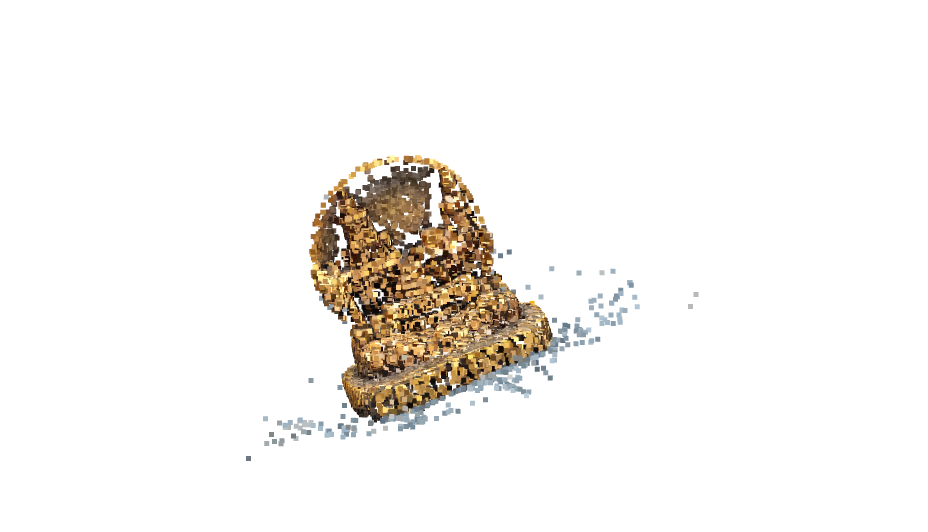

La visualización del modelo nos muestra muy buenos resultados, por lo que podemos decir que las imagenes que tomamos fueron de buena calidad para la detección de caracteristicas, lo que permitió que **incremental_mapping** realizara una reconstrucción 3D excelente.